<a href="https://colab.research.google.com/github/Marionabeel/deeplearning/blob/main/Deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [2]:
#hide
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

     |████████████████████████████████| 1.6MB 5.7MB/s 
     |████████████████████████████████| 552kB 22.6MB/s 
     |████████████████████████████████| 378kB 30.1MB/s 
     |████████████████████████████████| 122kB 27.2MB/s 
     |████████████████████████████████| 71kB 6.3MB/s 
     |████████████████████████████████| 430kB 18.8MB/s 
ERROR: nbdev 1.1.14 has requirement nbconvert<6, but you'll have nbconvert 6.0.7 which is incompatible.
ERROR: google-colab 1.0.0 has requirement tornado~=5.1.0; python_version >= "3.0", but you'll have tornado 6.1 which is incompatible.
  Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
  Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
      Successfully uninstalled tornado-5.1.1
  Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5


Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
Error loading server extension voila
      X is voila importable?


In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 5.4MB/s 
     |████████████████████████████████| 51kB 4.5MB/s 
     |████████████████████████████████| 194kB 8.9MB/s 
     |████████████████████████████████| 1.2MB 8.6MB/s 
     |████████████████████████████████| 61kB 5.3MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
     |████████████████████████████████| 12.8MB 44.6MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
Mounted at /content/gdrive


In [3]:
#hide
from fastbook import *
from fastai.vision.widgets import *

Clean

In [4]:
key = os.environ.get('AZURE_SEARCH_KEY', 'cb0ee9b7f13f4df08006bbfe02c14129')

In [5]:
search_images_bing(key, 'fruit')

(#150) [{'webSearchUrl': 'https://www.bing.com/images/search?view=detailv2&FORM=OIIRPO&q=fruit&id=9C51173906237ACFDB57D116674DC6C2F296AA5B&simid=608027104151370874', 'name': 'Can Fruit Make You Fat? - Nutritional Benefits, Reading, Berkshire', 'thumbnailUrl': 'https://tse1.mm.bing.net/th?id=OIP.MaRera5xQXBNg4FjFMzgqAHaE1&pid=Api', 'datePublished': '2020-05-16T11:27:00.0000000Z', 'isFamilyFriendly': True, 'contentUrl': 'https://www.nutritionalbenefits.co.uk/wp-content/uploads/2014/11/Fruit-Blog.jpg', 'hostPageUrl': 'http://www.nutritionalbenefits.co.uk/can-fruit-make-fat/', 'contentSize': '1504048 B', 'encodingFormat': 'jpeg', 'hostPageDisplayUrl': 'www.nutritionalbenefits.co.uk/can-fruit-make-fat', 'width': 5488, 'height': 3584, 'hostPageDiscoveredDate': '2014-11-24T00:00:00.0000000Z', 'thumbnail': {'width': 474, 'height': 309}, 'imageInsightsToken': 'ccid_MaRera5x*cp_E5568AE13CE6590767599F7C97DC6743*mid_9C51173906237ACFDB57D116674DC6C2F296AA5B*simid_608027104151370874*thid_OIP.MaRera5

In [6]:
results = search_images_bing(key, 'fruit')
ims = results.attrgot('contentUrl')
len(ims)

150

In [7]:
import os 
os.mkdir('images')

In [8]:
dest = 'images/banana.jpeg'
download_url(ims[0], dest)

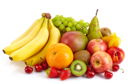

In [9]:
im = Image.open(dest)
im.to_thumb(128,128)

In [10]:
fruit_types = 'strawberry','banana','pineapple'
path = Path('fruit')

In [11]:
if not path.exists():
    path.mkdir()
    for o in fruit_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} fruit')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [12]:
fns = get_image_files(path)
fns

(#402) [Path('fruit/strawberry/00000109.jpg'),Path('fruit/strawberry/00000101.jpg'),Path('fruit/strawberry/00000010.jpg'),Path('fruit/strawberry/00000116.jpg'),Path('fruit/strawberry/00000146.jpg'),Path('fruit/strawberry/00000144.jpg'),Path('fruit/strawberry/00000148.jpg'),Path('fruit/strawberry/00000038.jpg'),Path('fruit/strawberry/00000141.jpg'),Path('fruit/strawberry/00000028.jpg')...]

In [13]:
failed = verify_images(fns)
failed

(#9) [Path('fruit/strawberry/00000138.jpg'),Path('fruit/strawberry/00000112.jpg'),Path('fruit/pineapple/00000060.jpg'),Path('fruit/pineapple/00000069.jpg'),Path('fruit/pineapple/00000134.jpg'),Path('fruit/pineapple/00000112.jpg'),Path('fruit/pineapple/00000064.jpg'),Path('fruit/pineapple/00000117.jpg'),Path('fruit/pineapple/00000147.jpg')]

In [14]:
failed.map(Path.unlink);

From data to dataloaders

In [15]:
fruits = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [16]:
dls = fruits.dataloaders(path)

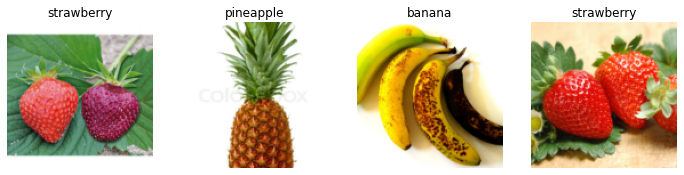

In [17]:
dls.valid.show_batch(max_n=4, nrows=1)

Training the model

In [18]:
fruits = fruits.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = fruits.dataloaders(path)

In [19]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.745673,2.664400,0.576923,01:20


epoch,train_loss,valid_loss,error_rate,time
0,0.709940,0.594078,0.243590,01:38
1,0.518383,0.153213,0.064103,01:37
2,0.407639,0.091640,0.025641,01:37
3,0.342805,0.076194,0.025641,01:37


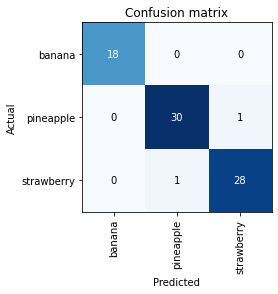

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

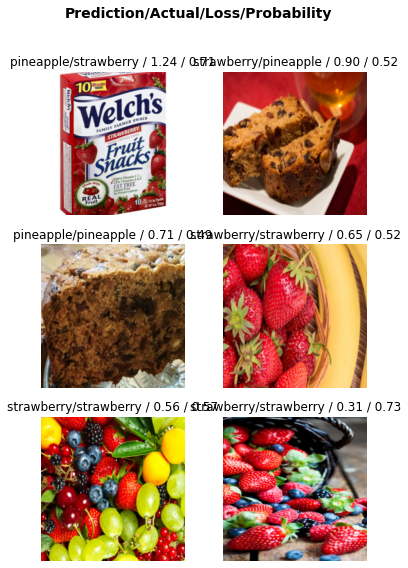

In [21]:
interp.plot_top_losses(6, nrows=3)

In [22]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

Turning the model into a online application

In [23]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [24]:
learn.export()

In [25]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [26]:
learn_inf = load_learner(path/'export.pkl')

In [27]:
learn_inf.predict('images/banana.jpeg')

('banana', tensor(0), tensor([9.9993e-01, 3.9172e-05, 3.0254e-05]))

In [28]:
learn_inf.dls.vocab

['banana', 'pineapple', 'strawberry']

In [29]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [30]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/banana.jpeg'])

In [31]:
img = PILImage.create(btn_upload.data[-1])

In [32]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [33]:
pred,pred_idx,probs = learn_inf.predict(img)

In [34]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: banana; Probability: 0.9999')

In [37]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [38]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [39]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [40]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [41]:
#hide_output
VBox([widgets.Label('Please, select your fruit!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

Turning your notebook into a real app